# Getting Started

This tutorial covers the bare minimum basics of working with NumPyro: how to install, run and how to apply use it to perform MCMC on a simple model. The central theme of this article is to keep things stripped down and simple for a user who is brand-new to NumPyro or bayesian modelling in general. If you're already a bit better equipped than this, you might consider Dan Foreman Mackey's [great tutorial](https://dfm.io/posts/intro-to-numpyro/) for applying NumPyro to astronomy, or head straight to the NumPyro documentation and its various [(broadly distributed) examples](https://num.pyro.ai/en/stable/).

## Installing NumPyro

If you're installing NumPyro for the first time with absolutely no prior knowledge, you'll find you have the easiest time if you're working on mac or some sort of linux system. If you're working on a windows machine, try using the [Windows Subsystem for Linux](https://learn.microsoft.com/en-us/windows/wsl/install) which will let you run all sorts of packages and software that don't play nicely with base windows. In this guide, I'll also strongly advise using a [conda](https://docs.conda.io/en/latest/) environment or something similar (e.g. [venv](https://docs.python.org/3/library/venv.html)). NumPyro and its dependencies can have significant changes between versions, particularly when using external modules like JAXNS's nested sampling, and so good version control is a must have.

**Setting Up an Environment**

Assuming you're running with conda on linux or wsl, the first item on the to-do list is making an environment to install all of our NumPyro packages to:

```
    conda create -n numpyroenv"
    conda install python
    conda install pip
```

And then activate this environment with:

```
    conda activate numpyroenv
```

You now have a conda environment running which safely contains all of the packages we'll need. `conda list` or `pip list` will show you everything you've got installed at the moment, including version numbers. If something is going wrong, this is a good place to start looking.

**Installing NumPyro & Its Dependencies**

First, install basic python packages that you'll need to do most anything with NumPyro. Note that many tutorials use the packages `corner` or `arviz` instead of `chainconsumer` for examining results.

```
    pip install numpy, matplotlib, chainconsumer
```

Now, install JAX, numpyro and their associated packages

```
    pip install jax, jaxlib, jaxopt
    pip install numpyro
```

If you're planning on using nested sampling with numpyro, you'll need the following. Note that we're installing a *specific version of jaxns*. At time of writing, NumPyro is not compatible with the versions of JAXNS 2.1.0 or greater.

```
    pip install etils, tensorflow_probability
    pip install jaxns==2.0.1
```


## Your First Model

In this section, we'll show how to use NumPyro to perform a simple linear regression using Bayesian MCMC on some simulated data. First, we need import all of the various packages we need. The second chunk of imports are just for plotting & doing maths, and aren't core to using NumPyro.

In [3]:
# JAX / NumPyro Imports
import jax, numpyro
import jax.numpy as jnp

# Plotting & Utilities
import matplotlib.pyplot as plt
import numpy as np
import chainconsumer

/home/hughmc/anaconda3/envs/nestconda_latest/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now the fun part: we'll use NumPy to hack together some data akin to the real world measurments you would apply NumPyro to. We'll both generate and fit according to a simple linear model:

\begin{equation}
    y(x) = m\cdot x + c
\end{equation}

In this example, we enjoy the luxury of already knowing the true underlying model *and* the true values its parameters (in this case, $m=2$ and $c=3.5$). We also choose a density and uncertainty of measurements to give a clear picture of the underlying model. The real world is rarely so friendly, and we have to bear in mind that any model is only an approximation of the messiness of reality. For an example on how to perform this, check the article on [Model Comparison & Tension](../tension/page.html).

In the cell below, `ebar` and `scatter` determine the average and spread of the size of errorbars in our data-points using a [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution). This sort of distribution is common in astronomy, as it's associated with count-based events like measuring flux from counting of photons.

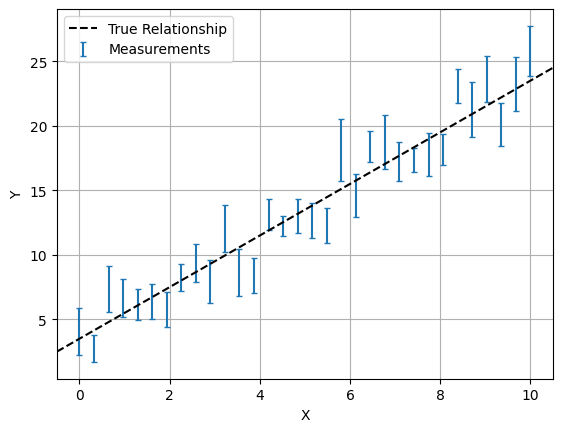

In [4]:
# Model 'truth' parameters
m_true = 2
c_true = 3.5

#----------------------------
# Data generation
ebar, escatter = 1.5, 10 # Average & spread of error bar

np.random.seed(123) # Fix the random seed so results are consitent across different examples
X = np.linspace(0,10,32)
E = np.random.poisson(lam=escatter, size=len(X)) / escatter * ebar
Y = m_true*X + c_true + E*np.random.normal(size=len(X)) # Linear rel /w random noise based on 'E'

#--------------
# Plotting
plt.figure()
plt.errorbar(X,Y,E,fmt='none', capsize=2, label='Measurements')
plt.axline( [0,c_true], slope=m_true, c='k', ls='--', label='True Relationship')
plt.legend(loc='best')
plt.xlabel("X"), plt.ylabel("Y")
plt.grid()
plt.show()

Now we can start using NumPyro to try and recover the $m$ and $c$ from these measurements. Our measurements here are _uncorrelated_, and so our test of "goodness of fit" for some guess at the parameters is:

\begin{equation}
    \mathcal{L}(m,c \vert y_i) = \exp \left(-\frac{\chi^2}{2} \right) =\exp \left(  -\frac{1}{2} \sum_i{\left(\frac{y_i-(m*x_i+c)}{E_i}\right)^2} \right)
\end{equation}

And this likelihood is modulated by our prior knowledge about $m$ and $c$. In a simple case like this, we can just set these to be sufficiently vague, e.g. a broad uniform distribution.

\begin{eqnarray}
    m & \sim & U(-5,5)\\ 
    c & \sim & U(-10,10)
\end{eqnarray}

Making a NumPyro model that encodes this model is surprisingly simple, and can be done in only a few lines of code:

In [5]:
def model(X,Y,E):
    m = numpyro.sample("m", numpyro.distributions.Uniform(-5,5))   # prior on m
    c = numpyro.sample("c", numpyro.distributions.Uniform(-10,10)) # Prior on c

    with numpyro.plate('data', len(X)):
        y_model = m*X + c
        numpyro.sample('y', numpyro.distributions.Normal(y_model,E), obs = Y)

Though written as a python function, `model(X,Y,E)` doesn't necessarily work like one, e.g. we don't "return" a likelihood. Instead, each `numpyro.sample` statement implies an effect on the likelihood:

*  The first two lines describe our prior knowledge about $m$ and $c$:
    *  The first argument, e.g. `"m"` is the "site name", the unique name that NumPyro will internally recognise this variable as and return its results as
    *  The python-like variable name `m` on the left hand side is only for using that variable within the function, like we do when we calculate `y_model`
*  The 'plate' describes the way we sweep over the datapoints in $\sum_i(y_i-y_{model})$.
    *  Everything created or called inside the plate is implicitly vectorized where possible, e.g. calling `X` when calculating `y_model` implicitly means `X[i]`
    *  The sample `y` follows a normal distribution $y\sim~N(y_{model},E)$, representing our uncorrelated measurements, and the `obs=Y` means that this distribution is being compared to the measurement `Y[i]`
    *  The sample `y` doesn't have a name on the LHS because we don't use it to do any more calculations

The `plate` object in NumPyro can be a little unintuitive because of the way it draws from vectors without stating so outright. To make things clearer, the following model would return exactly the same results, though not as cleanly:

In [6]:
%%script echo " " 
#Cell for demonstration only. Above line makes sure it doesn't run

def model(X,Y,E):
    m = numpyro.sample('m', numpyro.distributions.Uniform(-5,5)) # prior on m
    c = numpyro.sample('c', numpyro.distributions.Uniform(-5,5)) # Prior on c

    y_model = m*X + c
    
    for i in range(len(X)):
        numpyro.sample('y_%i' %i, numpyro.distributions.Normal(y_model[i], E[i]), obs=Y[i])

If you have `graphviz` installed, (e.g. via `conda install -c conda-forge pygraphviz`), NumPyro can automatically render a [graph of the model](https://en.wikipedia.org/wiki/Graphical_model#Bayesian_network) to help visualize it and confirm that everything's set up properly. This is called with:

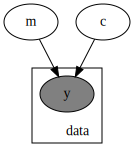

In [7]:
numpyro.render_model(model, model_args=(X,Y,E))

## Doing MCMC in NumPyro

Our NumPyro model encodes all of our probability distributions and data, now we need to actually _do_ something with it. In 90% of cases, that "something" will be constraining parameters with some kind of [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) algorithm. In NumPyro, we do this by creating an `MCMC` object and then triggering it with the `.run` method:

In [12]:
sampler = numpyro.infer.MCMC(numpyro.infer.NUTS(model), 
                             num_chains  = 1, 
                             num_samples = 5000, 
                             num_warmup  = 500)
sampler.run(jax.random.PRNGKey(1), X,Y,E)

sample: 100%|█████████| 5500/5500 [00:02<00:00, 2547.54it/s, 7 steps of size 2.95e-01. acc. prob=0.93]


When the `numpyro.infer.MCMC` object is created, we feed it a `numpyro.infer.NUTS` object, which in turn wraps around our probabalistic model. This argument determines what kind of MCMC sampler we use (in this case the No U-Turn Sampler (NUTS)). You can think of the `.infer.NUTS` sampler as being the actual machine for sampling parameter space, and the `.infer.MCMC` object as being a "handler" that controls it.  If you want to use a different sampler (e.g. the crude but less expensive [sample adaptive](https://num.pyro.ai/en/latest/mcmc.html#numpyro.infer.sa.SA) sampler), we can swap this first argument out. You can find a list of all [NumPyro's standard samplers](https://num.pyro.ai/en/latest/mcmc.html) in its documentation.

Because MCMC is an inherently random process, we need to feed it a random seed to determine how its stochastic elements are generated. This takes the form of the `jax.random.PRNGKey(i)` argument in `sampler.run()`. You might notice that we also feed the data, `X,Y` and `E` into the sampler when running. This means that the _same MCMC object can be used for fitting multiple data sets_.

Once the sampler has finished running, we just extract its completed MCMC chains using `.get_samples()`, which returns as a dictionary keyed by the NumPyro site names we defined in our model. We can then pass these directly to a chainconsumer object. 

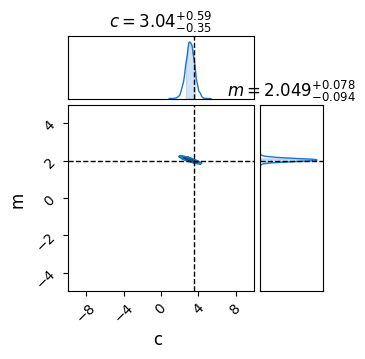

In [14]:
results = sampler.get_samples() # Dictionary of MCMC samples
C = chainconsumer.ChainConsumer()
C.add_chain(results, name = "MCMC Results")
C.plotter.plot(
    extents={'m': [-5,5], 'c':[-10,10]}, 
    truth = {'m':m_true, 'c':c_true})

plt.show()

Small adjustments to this simple case will cover most basic cases of using NumPyro, but you can still find yourself limited in two main ways:
1. Raw MCMC outputs are un-normalized, and so they don't tell us anything about how well the model performs, only how well it constrains parameters. For that, we need to use some kind of [model comparison](../modelcomparison/page.html) technique.
2. Most MCMC samplers (including NUTS) fail in multimodal distributions. NUTS fails when there is more than one 'island' of probability, and fails entirely if the likelihood function is 'bumpy' in between these island. In these cases, we need to either [post-process](../multimodality/page.html) our chains or use a more robust sampler like [nested sampling](../nestedsampling/page.html).